<a href="https://colab.research.google.com/github/fkdia23/Data-Engineering-tools-for-Software-engineer/blob/master/Projet_1_apprentissage_profond_par_renforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub

In [ ]:
import os
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten, Input
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU, MaxPooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from collections import deque
import random
import cv2
from gym import spaces
import time


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


In [ ]:
data_path = path
train_path = os.path.join(data_path, 'seg_train', 'seg_train')
test_path = os.path.join(data_path, 'seg_test', 'seg_test')
pred_path = os.path.join(data_path, 'seg_pred', 'seg_pred')

In [ ]:
 # Configuration
BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = 224
NUM_CLASSES = 6
TRAIN_DIR = train_path
TEST_DIR = test_path

# Répertoires pour sauvegarder les modèles et les résultats
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [ ]:
# 1. Chargement et prétraitement des données
def load_and_preprocess_data():
    print("Chargement et prétraitement des données...")

    # Générateurs de données pour l'entraînement et la validation
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    # Chargement des données d'entraînement avec split validation
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    # Chargement des données de test
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

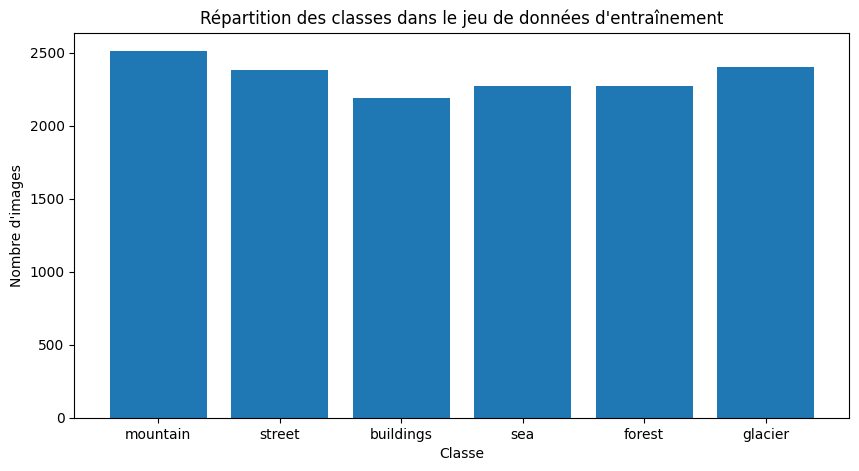

Nombre d'images par classe: {'mountain': 2512, 'street': 2382, 'buildings': 2191, 'sea': 2274, 'forest': 2271, 'glacier': 2404}


In [ ]:
# Obtenir les noms des classes (sous-dossiers)
class_names = os.listdir(TRAIN_DIR)
num_classes = len(class_names)

# Compter le nombre d'images par classe
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(TRAIN_DIR, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Visualiser la répartition des classes
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Répartition des classes dans le jeu de données d\'entraînement')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'images')
plt.show()

print("Nombre d'images par classe:", class_counts)

In [ ]:
# 2. Création du modèle CNN (ResNet50)
def create_cnn_model():
    print("Création du modèle CNN (ResNet50)...")

    # Chargement du modèle ResNet50 préentraîné
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Congélation des couches du modèle de base
    for layer in base_model.layers:
        layer.trainable = False

    # Ajout des couches personnalisées
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    # Création du modèle final
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilation du modèle
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
def train_cnn_model(model, train_generator, validation_generator):
    print("Entraînement du modèle CNN...")

    # Callbacks pour sauvegarder le meilleur modèle et arrêter l'entraînement si nécessaire
    checkpoint = ModelCheckpoint(
        'models/cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        mode='max',
        verbose=1
    )

    # Entraînement du modèle
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpoint, early_stopping]
    )

    return model, history

In [ ]:
train_generator, validation_generator, test_generator = load_and_preprocess_data()


Chargement et prétraitement des données...
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
   # 2. Création et entraînement du modèle CNN
cnn_model = create_cnn_model()
cnn_model, history = train_cnn_model(cnn_model, train_generator, validation_generator)

Création du modèle CNN (ResNet50)...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Entraînement du modèle CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.8204 - loss: 0.5149
Epoch 1: val_accuracy improved from -inf to 0.89763, saving model to models/cnn_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 315s 856ms/step - accuracy: 0.8205 - loss: 0.5145 - val_accuracy: 0.8976 - val_loss: 0.2876
Epoch 2/10
  1/350 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.9375 - loss: 0.2036

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.89763 to 0.89943, saving model to models/cnn_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - accuracy: 0.9375 - loss: 0.2036 - val_accuracy: 0.8994 - val_loss: 0.2764
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9009 - loss: 0.2659
Epoch 3: val_accuracy did not improve from 0.89943
350/350 ━━━━━━━━━━━━━━━━━━━━ 201s 575ms/step - accuracy: 0.9009 - loss: 0.2658 - val_accuracy: 0.8937 - val_loss: 0.3148
Epoch 4/10
  1/350 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.8438 - loss: 0.3616
Epoch 4: val_accuracy did not improve from 0.89943
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.8438 - loss: 0.3616 - val_accuracy: 0.8958 - val_loss: 0.2780
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9176 - loss: 0.2231
Epoch 5: val_accuracy improved from 0.89943 to 0.91236, saving model to models/cnn_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 213s 545ms/step - accuracy: 0.9175 - loss: 0.2232 - val_accuracy: 0.9124 - val_loss: 0.2400
Epoch 6/10
  1/350 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.9375 - loss: 0.1877
Epoch 6: val_accuracy improved from 0.91236 to 0.91810, saving model to models/cnn_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.9375 - loss: 0.1877 - val_accuracy: 0.9181 - val_loss: 0.2320
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9204 - loss: 0.2159
Epoch 7: val_accuracy did not improve from 0.91810
350/350 ━━━━━━━━━━━━━━━━━━━━ 223s 546ms/step - accuracy: 0.9204 - loss: 0.2159 - val_accuracy: 0.9149 - val_loss: 0.2313
Epoch 8/10
  1/350 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - accuracy: 0.9688 - loss: 0.1257
Epoch 8: val_accuracy did not improve from 0.91810
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - accuracy: 0.9688 - loss: 0.1257 - val_accuracy: 0.9177 - val_loss: 0.2339
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9194 - loss: 0.2162
Epoch 9: val_accuracy did not improve from 0.91810
350/350 ━━━━━━━━━━━━━━━━━━━━ 189s 540ms/step - accuracy: 0.9195 - loss: 0.2162 - val_accuracy: 0.9109 - val_loss: 0.2656
Epoch 10/10
  1/350 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step - accuracy: 0.9375 - loss: 0.0977
Epoch 10: v

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Charger le meilleur modèle sauvegardé
cnn_model.load_weights('models/cnn_model.h5')

# Prédire les étiquettes sur l'ensemble de validation
validation_generator.reset()  # Réinitialiser le générateur de validation
Y_pred = cnn_model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Calculer et afficher la matrice de confusion
cm = confusion_matrix(y_true, y_pred)
print("Matrice de confusion :")
print(cm)

# Afficher le rapport de classification
print("Rapport de classification :")
print(classification_report(y_true, y_pred))


88/88 ━━━━━━━━━━━━━━━━━━━━ 48s 487ms/step
Matrice de confusion :
[[63 84 60 84 69 78]
 [67 74 86 77 78 72]
 [75 72 83 77 90 83]
 [76 73 93 94 82 84]
 [83 76 72 84 62 77]
 [83 74 80 89 80 70]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.14      0.14      0.14       438
           1       0.16      0.16      0.16       454
           2       0.18      0.17      0.17       480
           3       0.19      0.19      0.19       502
           4       0.13      0.14      0.14       454
           5       0.15      0.15      0.15       476

    accuracy                           0.16      2804
   macro avg       0.16      0.16      0.16      2804
weighted avg       0.16      0.16      0.16      2804



In [ ]:
# 4. Définition de l'environnement Gym personnalisé
class ImageEnv(gym.Env):
    def __init__(self, data_generator, cnn_model, max_steps=30):
        super(ImageEnv, self).__init__()
        self.data_generator = data_generator
        self.cnn_model = cnn_model
        self.max_steps = max_steps

        # Espace d'action (6 actions: haut, bas, gauche, droite, zoom, terminer)
        self.action_space = spaces.Discrete(6)

        # Espace d'observation (image RGB 224x224x3)
        self.observation_space = spaces.Box(
            low=0, high=255, shape=(IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8
        )

        # Paramètres de la fenêtre de focus
        self.window_size = IMG_SIZE
        self.min_window_size = IMG_SIZE // 4
        self.step_size = IMG_SIZE // 10
        self.zoom_factor = 0.9

        # Chargement d'une image et de sa classe
        self.current_image = None
        self.current_label = None
        self.current_window = None
        self.steps_without_improvement = 0
        self.best_reward = 0.0

        # Position actuelle de la fenêtre
        self.x = 0
        self.y = 0
        self.width = IMG_SIZE
        self.height = IMG_SIZE

    def reset(self):
          # Récupération d'une nouvelle image et de sa classe
          batch = next(self.data_generator)
          self.current_image = batch[0][0]  # Première image du batch
          self.current_label = np.argmax(batch[1][0])  # Classe de la première image

          # Réinitialisation de la fenêtre de focus
          self.x = 0
          self.y = 0
          self.width = IMG_SIZE
          self.height = IMG_SIZE
          self.steps_without_improvement = 0
          self.best_reward = 0.0

          # Extraction de la région actuelle
          self.current_window = self.extract_window()

          return self.current_window

    def extract_window(self):
        # Extraction de la région actuelle à partir de l'image complète
        x_start = max(0, self.x)
        y_start = max(0, self.y)
        x_end = min(IMG_SIZE, self.x + self.width)
        y_end = min(IMG_SIZE, self.y + self.height)

        # Extraction de la région
        region = self.current_image[y_start:y_end, x_start:x_end]

        # Redimensionnement à la taille attendue par le CNN
        resized_region = cv2.resize(region, (IMG_SIZE, IMG_SIZE))

        return resized_region

    def step(self, action):
      # Déplacement ou redimensionnement de la fenêtre en fonction de l'action
      if action == 0:  # Haut
          self.y = max(0, self.y - self.step_size)
      elif action == 1:  # Bas
          self.y = min(IMG_SIZE - self.height, self.y + self.step_size)
      elif action == 2:  # Gauche
          self.x = max(0, self.x - self.step_size)
      elif action == 3:  # Droite
          self.x = min(IMG_SIZE - self.width, self.x + self.step_size)
      elif action == 4:  # Zoom
          # Calcul des nouvelles dimensions
          new_width = max(self.min_window_size, int(self.width * self.zoom_factor))
          new_height = max(self.min_window_size, int(self.height * self.zoom_factor))

          # Calcul des nouveaux points d'origine pour garder le centre de la fenêtre
          center_x = self.x + self.width // 2
          center_y = self.y + self.height // 2
          new_x = center_x - new_width // 2
          new_y = center_y - new_height // 2

          # Mise à jour des paramètres de la fenêtre
          self.x = max(0, min(IMG_SIZE - new_width, new_x))
          self.y = max(0, min(IMG_SIZE - new_height, new_y))
          self.width = new_width
          self.height = new_height

      # Extraction de la nouvelle région
      self.current_window = self.extract_window()

      # Calcul de la récompense si action = terminer ou nombre max d'étapes atteint
      done = (action == 5) or (self.steps_without_improvement >= self.max_steps)
      reward = 0.0

      if done:
          # Prétraitement de l'image pour le CNN
          img = np.expand_dims(self.current_window, axis=0)
          img = preprocess_input(img)

          # Prédiction avec le CNN
          predictions = self.cnn_model.predict(img)[0]

          # La récompense est la probabilité de la classe correcte
          predicted_class = np.argmax(predictions)
          reward = predictions[self.current_label]

          # Pénalité si la classe prédite est incorrecte
          if predicted_class != self.current_label:
              reward *= 0.5

      # Mise à jour du compteur d'étapes sans amélioration
      if reward > self.best_reward:
          self.best_reward = reward
          self.steps_without_improvement = 0
      else:
          self.steps_without_improvement += 1

      # Informations supplémentaires
      info = {
          'x': self.x,
          'y': self.y,
          'width': self.width,
          'height': self.height,
          'steps_without_improvement': self.steps_without_improvement
      }

      return self.current_window, reward, done, info


In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
# 5. Implémentation de l'agent SARSA
class SARSAAgent:
    def __init__(self, state_shape, num_actions, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, gamma=0.99, learning_rate=0.001, buffer_size=10000):
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.learning_rate = learning_rate

        # Création du modèle de Q-function
        self.model = self._build_model()

        # Replay buffer
        self.buffer_size = buffer_size
        self.replay_buffer = deque(maxlen=buffer_size)

    def _build_model(self):
        # Modèle pour approximer la fonction Q
        #model = Sequential([
        #    Conv2D(16, (3, 3), activation='relu', input_shape=self.state_shape),
        #    Conv2D(32, (3, 3), activation='relu'),
        #    Conv2D(32, (3, 3), activation='relu'),
        #    Flatten(),
        #    Dense(256, activation='relu'),
        #    Dense(self.num_actions, activation='linear')
        #])

        model = Sequential([
            Conv2D(16, (3, 3), activation=None, input_shape=self.state_shape, kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            LeakyReLU(negative_slope=0.1),  # Utiliser `negative_slope` au lieu de `alpha`
            Dropout(0.2),

            Conv2D(32, (3, 3), activation=None, kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            LeakyReLU(negative_slope=0.1),
            Dropout(0.2),

            Conv2D(32, (3, 3), activation=None, kernel_regularizer=l2(0.001)),  # Réduire le nombre de filtres
            BatchNormalization(),
            LeakyReLU(negative_slope=0.1),
            Dropout(0.2),

            Flatten(),

            Dense(128, activation=None, kernel_regularizer=l2(0.001)),  # Réduire le nombre de neurones
            BatchNormalization(),
            LeakyReLU(negative_slope=0.1),
            Dropout(0.5),

            Dense(self.num_actions, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def choose_action(self, state):
        # Politique epsilon-greedy
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)

        # Prétraitement de l'état
        state = np.expand_dims(state, axis=0)
        state = preprocess_input(state)

        # Prédiction des valeurs Q
        q_values = self.model.predict(state)[0]
        return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, next_action, done):
        # Stockage de l'expérience dans le replay buffer
        self.replay_buffer.append((state, action, reward, next_state, next_action, done))

    def train(self, batch_size=32):
        # Vérification de la taille du replay buffer
        if len(self.replay_buffer) < batch_size:
            return

        # Échantillonnage aléatoire d'un batch d'expériences
        minibatch = random.sample(self.replay_buffer, batch_size)

        for state, action, reward, next_state, next_action, done in minibatch:
            # Prétraitement des états
            state = np.expand_dims(state, axis=0)
            state = preprocess_input(state)

            next_state = np.expand_dims(next_state, axis=0)
            next_state = preprocess_input(next_state)

            # Calcul de la cible pour l'entraînement (règle de mise à jour SARSA)
            target = reward
            if not done:
                target += self.gamma * self.model.predict(next_state)[0][next_action]

            # Mise à jour des valeurs Q
            target_f = self.model.predict(state)
            target_f[0][action] = target

            # Entraînement du modèle
            self.model.fit(state, target_f, epochs=1, verbose=0)

        # Décroissance du epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, filepath):
        self.model.save(filepath)

    def load(self, filepath):
        self.model = tf.keras.models.load_model(filepath)

In [ ]:
def train_sarsa_agent(env, agent, num_episodes=1000, batch_size=32, save_interval=100):
    print("Entraînement de l'agent SARSA...")

    # Historique des récompenses
    rewards_history = []

    for episode in range(num_episodes):
        # Réinitialisation de l'environnement
        state = env.reset()
        action = agent.choose_action(state)
        total_reward = 0
        done = False

        while not done:
            # Exécution de l'action
            next_state, reward, done, _ = env.step(action)

            # Choix de la prochaine action (nécessaire pour SARSA)
            next_action = agent.choose_action(next_state)

            # Stockage de l'expérience
            agent.remember(state, action, reward, next_state, next_action, done)

            # Entraînement de l'agent
            agent.train(batch_size)

            # Mise à jour de l'état et de l'action
            state = next_state
            action = next_action

            # Accumulation des récompenses
            total_reward += reward

        # Enregistrement de la récompense totale
        rewards_history.append(total_reward)

        # Affichage de la progression
        if (episode + 1) % 10 == 0:
            print(f"Épisode {episode + 1}/{num_episodes}, Récompense: {total_reward:.4f}, Epsilon: {agent.epsilon:.4f}")

        # Sauvegarde du modèle à intervalles réguliers
        if (episode + 1) % save_interval == 0:
            agent.save(f"models/sarsa_agent_episode_{episode + 1}.h5")

    # Sauvegarde du modèle final
    agent.save("models/sarsa_agent_final.h5")

    # Sauvegarde de l'historique des récompenses
    np.save("results/rewards_history.npy", np.array(rewards_history))

    return rewards_history

In [ ]:
# 7. Fonction d'évaluation de l'agent SARSA
def evaluate_agent(env, agent, num_episodes=100):
    print("Évaluation de l'agent SARSA...")

    rewards = []
    accuracies = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state

        rewards.append(reward)

        # Calcul de l'exactitude (1 si la prédiction est correcte, 0 sinon)
        img = np.expand_dims(state, axis=0)
        img = preprocess_input(img)
        prediction = np.argmax(env.cnn_model.predict(img)[0])
        accuracy = 1 if prediction == env.current_label else 0
        accuracies.append(accuracy)

    avg_reward = np.mean(rewards)
    avg_accuracy = np.mean(accuracies)

    print(f"Récompense moyenne: {avg_reward:.4f}")
    print(f"Précision moyenne: {avg_accuracy:.4f}")

    return avg_reward, avg_accuracy

In [ ]:
# 8. Fonction d'évaluation du modèle CNN de base (sans RL)
def evaluate_baseline_cnn(model, test_generator):
    print("Évaluation du modèle CNN de base...")

    # Évaluation du modèle sur les données de test
    scores = model.evaluate(test_generator)

    print(f"Perte: {scores[0]:.4f}")
    print(f"Précision: {scores[1]:.4f}")

    return scores


# 9. Visualisation des résultats
def visualize_results(rewards_history, baseline_accuracy, rl_accuracy):
    print("Visualisation des résultats...")

    # Tracé de l'historique des récompenses
    plt.figure(figsize=(10, 5))
    plt.plot(rewards_history)
    plt.title('Évolution des récompenses au cours de l\'entraînement')
    plt.xlabel('Épisode')
    plt.ylabel('Récompense')
    plt.savefig('results/rewards_history.png')

    # Comparaison des précisions
    plt.figure(figsize=(8, 6))
    models = ['CNN de base', 'CNN + RL']
    accuracies = [baseline_accuracy, rl_accuracy]
    plt.bar(models, accuracies, color=['blue', 'green'])
    plt.title('Comparaison des précisions')
    plt.ylabel('Précision')
    plt.ylim(0, 1)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
    plt.savefig('results/accuracy_comparison.png')

    plt.show()

# 10. Visualisation des régions sélectionnées par l'agent
def visualize_selected_regions(env, agent, num_samples=5):
    print("Visualisation des régions sélectionnées...")

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 3 * num_samples))

    for i in range(num_samples):
        # Réinitialisation de l'environnement
        state = env.reset()
        done = False

        # Image originale
        original_image = env.current_image.copy()

        # Navigation de l'agent
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, info = env.step(action)
            state = next_state

        # Dessin de la région sélectionnée sur l'image originale
        marked_image = original_image.copy()
        x, y, width, height = info['x'], info['y'], info['width'], info['height']
        cv2.rectangle(marked_image, (x, y), (x + width, y + height), (0, 255, 0), 2)

        # Affichage des images
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title(f"Original (Classe: {env.current_label})")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(marked_image)
        axes[i, 1].set_title("Région sélectionnée")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig('results/selected_regions.png')
    plt.show()


In [ ]:
# 3. Évaluation du modèle CNN de base
baseline_scores = evaluate_baseline_cnn(cnn_model, test_generator)
baseline_accuracy = baseline_scores[1]


Évaluation du modèle CNN de base...
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.9323 - loss: 0.1764
Perte: 0.2039
Précision: 0.9250


In [ ]:
# 4. Création de l'environnement RL
env = ImageEnv(test_generator, cnn_model)

In [ ]:
# 5. Création et entraînement de l'agent SARSA
agent = SARSAAgent(
    state_shape=(IMG_SIZE, IMG_SIZE, 3),
    num_actions=6,
    epsilon=1.0,
    epsilon_min=0.1,
    epsilon_decay=0.995,
    gamma=0.99,
    learning_rate=0.001,
    buffer_size=10000
)



In [ ]:
rewards_history = train_sarsa_agent(env, agent, num_episodes=30, batch_size=16, save_interval=50)


Entraînement de l'agent SARSA...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━

Épisode 30/30, Récompense: 0.7996, Epsilon: 0.6433


In [ ]:

# 6. Évaluation de l'agent SARSA
avg_reward, rl_accuracy = evaluate_agent(env, agent, num_episodes=50)


Évaluation de l'agent SARSA...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━

Visualisation des résultats...


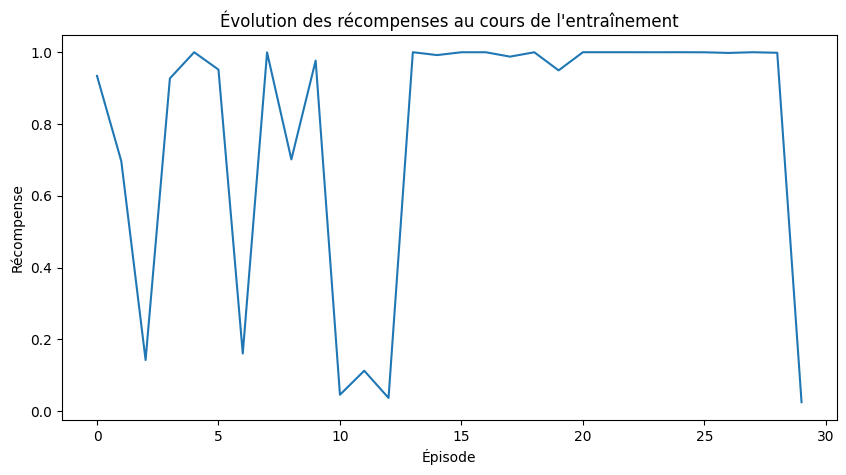

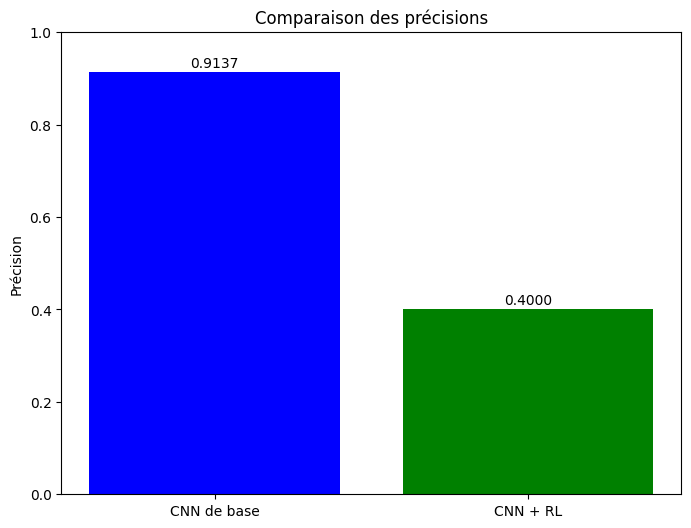

In [ ]:
# 7. Visualisation des résultats
visualize_results(rewards_history, baseline_accuracy, rl_accuracy)



Visualisation des régions sélectionnées...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


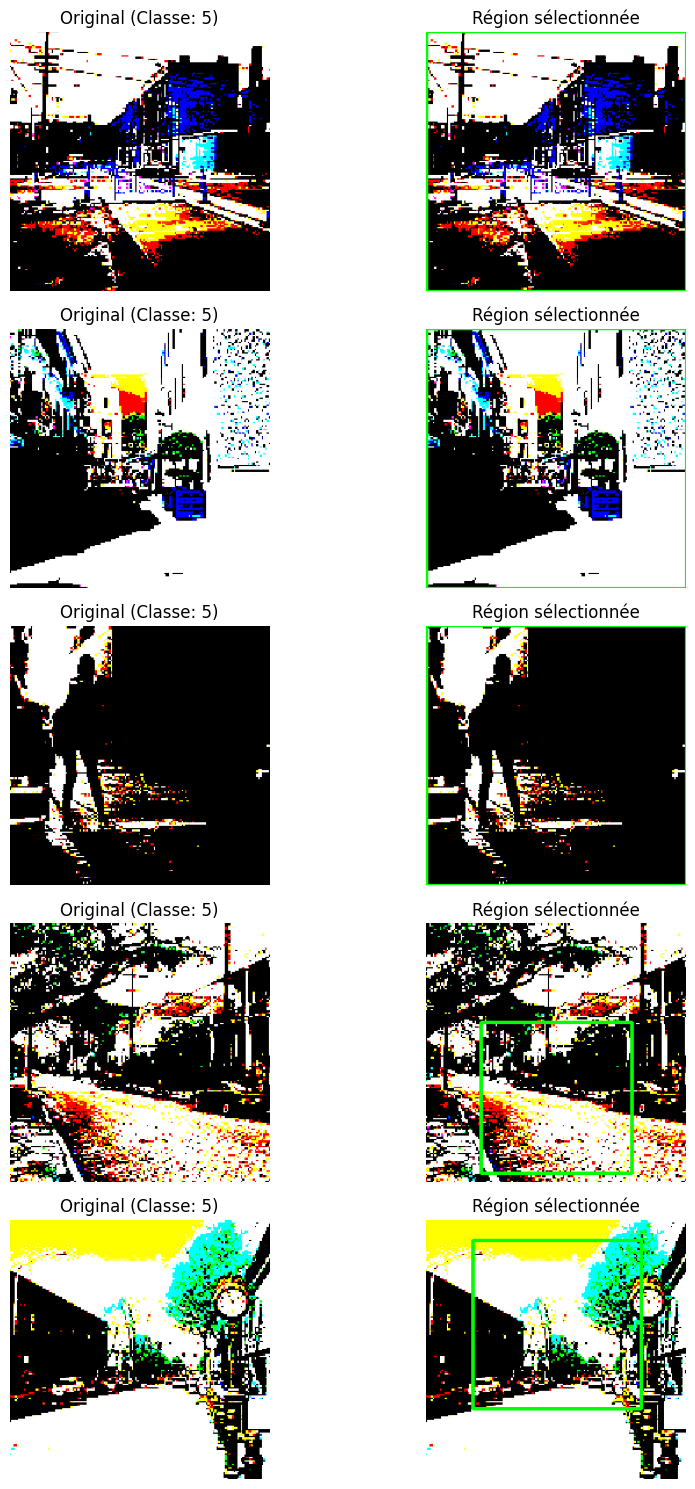

Projet terminé avec succès !


In [ ]:
# 8. Visualisation des régions sélectionnées
visualize_selected_regions(env, agent, num_samples=5)

print("Projet terminé avec succès !")